In [8]:
import os
import json
import pickle
import random
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from datetime import datetime
from scipy.stats import fisher_exact, mannwhitneyu

# 1. Prepare Data

# 1.1 Download Co-Edit Data

In [9]:
from data_util import get_edit_data, get_editors_by_type

DATA_DIR = "data"

In [10]:
# image_items = get_edit_data("image", limit=50000)
# image_items.to_csv(os.path.join(DATA_DIR, "items", "image_items.csv"))

# video_items = get_edit_data("video", limit=50000)
# video_items.to_csv(os.path.join(DATA_DIR, "items", "video_items.csv"))

# audio_items = get_edit_data("audio", limit=50000)
# audio_items.to_csv(os.path.join(DATA_DIR, "items", "audio_items.csv"))

In [11]:
# image_editors_df = get_editors_by_type("image", DATA_DIR)
# image_editors_df.to_csv(os.path.join(DATA_DIR, "multi-media_editors", ("image_editors.csv")))

# video_editors_df = get_editors_by_type("video", DATA_DIR)
# video_editors_df.to_csv(os.path.join(DATA_DIR, "multi-media_editors", ("video_editors.csv")))

# audio_editors_df = get_editors_by_type("audio", DATA_DIR)
# audio_editors_df.to_csv(os.path.join(DATA_DIR, "multi-media_editors", ("audio_editors.csv")))

## 1.2 Filter Data

Only keep entries that contain at least two types of multimedia formats (image, video, audio).

In [12]:
# 读取数据
image_editors_df = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "image_editors_wt.csv"), index_col="Unnamed: 0")
audio_editors_df = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "video_editors_wt.csv"), index_col="Unnamed: 0")
video_editors_df = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "audio_editors_wt.csv"), index_col="Unnamed: 0")

print("image 条目数量：", len(image_editors_df.item.unique()))
print("audio 条目数量：", len(audio_editors_df.item.unique()))
print("video 条目数量：", len(video_editors_df.item.unique()))

# 计算交集
ixa_item = np.intersect1d(image_editors_df.item.unique(), audio_editors_df.item.unique())
ixv_item = np.intersect1d(image_editors_df.item.unique(), video_editors_df.item.unique())
axv_item = np.intersect1d(video_editors_df.item.unique(), audio_editors_df.item.unique())
iav_item = np.intersect1d(image_editors_df.item.unique(), axv_item)
items = np.unique(np.concatenate([ixa_item, ixv_item, axv_item]).flatten())
print("至少两种形式的多媒体条目数量：", len(items))

# 过滤数据
filtered_img_df = image_editors_df[image_editors_df.item.isin(items)]
filtered_aud_df = audio_editors_df[audio_editors_df.item.isin(items)]
filtered_vid_df = video_editors_df[video_editors_df.item.isin(items)]
data_df = pd.concat([filtered_img_df, filtered_aud_df, filtered_vid_df]).drop_duplicates()

num_sample_item = 10
sample_data_df = data_df[data_df.item.isin(data_df.item.unique()[:num_sample_item])]
print("至少两种形式的多媒体条目的总共编辑数：", len(data_df))
print(f"取前{num_sample_item}个条目作为sample来调试，sample大小为：", len(sample_data_df))

# 保存数据
# data_df.to_csv(os.path.join(DATA_DIR, "multi-media_editors", "2type_editors_full.csv"))
# sample_data_df.to_csv(os.path.join(DATA_DIR, "multi-media_editors", f"2type_editors_sample_{num_sample_item}.csv"))

image 条目数量： 47027
audio 条目数量： 13271
video 条目数量： 8451
至少两种形式的多媒体条目数量： 828
至少两种形式的多媒体条目的总共编辑数： 228546
取前10个条目作为sample来调试，sample大小为： 3806


## 1.3 User Info

In [13]:
full_edit_records = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "2type_editors_full.csv"), index_col="Unnamed: 0")
full_edit_records

,editor,item,timestamp
898,MatSuBot,Q82194,2023-12-04T11:15:06Z
899,Luan,Q82194,2023-11-30T14:46:16Z
900,Lombroso,Q82194,2023-11-25T03:43:04Z
901,Senior Forte,Q82194,2023-11-20T10:38:48Z
902,PGS 1984,Q82194,2023-10-25T12:03:39Z
...,...,...,...
150659,Сергій Липко,Q30026843,2017-05-23T18:05:16Z
150660,Сергій Липко,Q30026843,2017-05-23T18:03:42Z
150661,Сергій Липко,Q30026843,2017-05-23T18:03:19Z
150662,Сергій Липко,Q30026843,2017-05-23T18:03:09Z


In [14]:
image_editors_df = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "image_editors_wt.csv"), index_col="Unnamed: 0")
audio_editors_df = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "video_editors_wt.csv"), index_col="Unnamed: 0")
video_editors_df = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "audio_editors_wt.csv"), index_col="Unnamed: 0")

image_items = image_editors_df.item.unique()
audio_items = audio_editors_df.item.unique()
video_items = video_editors_df.item.unique()

cand_items = full_edit_records.item.unique()

image_map = {item: ext for item, ext in zip(cand_items, np.isin(cand_items, image_items))}
audio_map = {item: ext for item, ext in zip(cand_items, np.isin(cand_items, audio_items))}
video_map = {item: ext for item, ext in zip(cand_items, np.isin(cand_items, video_items))}

full_edit_records["image_item"] = full_edit_records.item.apply(lambda x: image_map[x])
full_edit_records["audio_item"] = full_edit_records.item.apply(lambda x: audio_map[x])
full_edit_records["video_item"] = full_edit_records.item.apply(lambda x: video_map[x])
full_edit_records.timestamp = full_edit_records.timestamp.apply(lambda x: x[:x.index("T")])

editor_data = {editor: grp_df for editor, grp_df in full_edit_records.groupby("editor")}
full_edit_records

,editor,item,timestamp,image_item,audio_item,video_item
898,MatSuBot,Q82194,2023-12-04,True,True,False
899,Luan,Q82194,2023-11-30,True,True,False
900,Lombroso,Q82194,2023-11-25,True,True,False
901,Senior Forte,Q82194,2023-11-20,True,True,False
902,PGS 1984,Q82194,2023-10-25,True,True,False
...,...,...,...,...,...,...
150659,Сергій Липко,Q30026843,2017-05-23,False,True,True
150660,Сергій Липко,Q30026843,2017-05-23,False,True,True
150661,Сергій Липко,Q30026843,2017-05-23,False,True,True
150662,Сергій Липко,Q30026843,2017-05-23,False,True,True


In [111]:
full_edit_records.timestamp.min(), full_edit_records.timestamp.max()

('2012-10-29', '2024-06-22')

# 2. Construct Graph & Basic Graph Statistics

In [15]:
from graph_util import *

OUTPUT_DIR = "output"

In [40]:
# num_sample_item = None
num_sample_item = 10
if num_sample_item is None:
    G = construct_graph(pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", f"2type_editors_full.csv")))
else:
    G = construct_graph(pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", f"2type_editors_sample_{num_sample_item}.csv")))

In [38]:
number_of_nodes = G.number_of_nodes()
number_of_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / number_of_nodes

diameter = graph_diameter(G)
avg_path_length = average_path_length(G)
clustering_coeff = clustering_coefficient(G)


degree_c = degree_centrality(G)
betweenness_c = betweenness_centrality(G)
closeness_c = closeness_centrality(G)
eigenvector_c = eigenvector_centrality(G)


modularity_communities = modularity_optimization(G)


results = {
    "number_of_nodes": number_of_nodes,
    "number_of_edges": number_of_edges,
    "average_degree": average_degree,
    "diameter": diameter,
    "avg_path_length": avg_path_length,
    "clustering_coeff": clustering_coeff,
    "degree_centrality": degree_c,
    "betweenness_centrality": betweenness_c,
    "closeness_centrality": closeness_c,
    "eigenvector_centrality": eigenvector_c,
    "modularity_communities": modularity_communities,
    # "spectral_communities": spectral_clustering(G, k=3) 
}


if num_sample_item is None:
    output_file_path = os.path.join(OUTPUT_DIR, f"graph_stat.pkl")
else:
    output_file_path = os.path.join(OUTPUT_DIR, f"graph_stat_{num_sample_item}.pkl")
# with open(output_file_path, "wb") as f:
    # pickle.dump(results, f)

# 3. Hypothesis Testing

**Fisher's Exact Test**

Fisher's Exact Test is a statistical method used to analyze the association between two categorical variables. It can precisely calculate whether there is a significant association between two categorical variables without relying on approximate probability distributions.



**Mann-Whitney U**

The Mann-Whitney U test is a non-parametric statistical test used to compare whether there is a significant difference in the medians of two independent samples. It does not require the data to follow a normal distribution and is applicable to various types of data, including non-normally distributed data.

**Applications**
（1）Comparing two independent samples
（2）Data does not follow a normal distribution
（3）Small sample sizes or unclear data distribution


In [125]:
def two_test(G, feature='degree_centrality', start_year=2012, end_year=2025):
    time_periods = [(f"{year}-01-01", f"{year}-12-31") for year in range(start_year, end_year)]
    result = []
    for start, end in time_periods:
        start_date = datetime.strptime(start, "%Y-%m-%d")
        end_date = datetime.strptime(end, "%Y-%m-%d")

        image_contributions_count = 0
        video_contributions_count = 0
        audio_contributions_count = 0
        image_no_contributions_count = 0
        video_no_contributions_count = 0
        audio_no_contributions_count = 0

        image_centralities = []
        video_centralities = []
        audio_centralities = []

        for node in G.nodes:
            if 'image_contributions' in G.nodes[node]:
                image_contributions = sum(1 for count, date in G.nodes[node]['image_contributions'] if start_date <= datetime.strptime(date, "%Y-%m-%d") <= end_date)
            else:
                image_contributions = 0

            if 'video_contributions' in G.nodes[node]:
                video_contributions = sum(1 for count, date in G.nodes[node]['video_contributions'] if start_date <= datetime.strptime(date, "%Y-%m-%d") <= end_date)
            else:
                video_contributions = 0

            if 'audio_contributions' in G.nodes[node]:
                audio_contributions = sum(1 for count, date in G.nodes[node]['audio_contributions'] if start_date <= datetime.strptime(date, "%Y-%m-%d") <= end_date)
            else:
                audio_contributions = 0

            if image_contributions > 0:
                image_contributions_count += 1
                image_centralities.append(G.nodes[node][feature])
            else:
                image_no_contributions_count += 1

            if video_contributions > 0:
                video_contributions_count += 1
                video_centralities.append(G.nodes[node][feature])
            else:
                video_no_contributions_count += 1

            if audio_contributions > 0:
                audio_contributions_count += 1
                audio_centralities.append(G.nodes[node][feature])
            else:
                audio_no_contributions_count += 1
                
        contirbs = [image_contributions_count, image_no_contributions_count,
                    video_contributions_count, video_no_contributions_count,
                    audio_contributions_count, audio_no_contributions_count]

        # Fisher's Exact Test
        contingency_table = [[image_contributions_count, image_no_contributions_count], [video_contributions_count, video_no_contributions_count]]
        oddsratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

        # Mann-Whitney U
        stat, mw_p_value = mannwhitneyu(image_centralities, video_centralities)

        result.append([int(start[:4]), start, end, "image-video", oddsratio, p_value, "Fisher's Exact Test"] + contirbs)
        result.append([int(start[:4]), start, end, "image-video", stat, mw_p_value, "Mann-Whitney U"] + contirbs)

        # Fisher's Exact Test
        contingency_table = [[audio_contributions_count, audio_no_contributions_count], [video_contributions_count, video_no_contributions_count]]
        oddsratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

        # Mann-Whitney U
        stat, mw_p_value = mannwhitneyu(audio_centralities, video_centralities)

        result.append([int(start[:4]), start, end, "audio-video", oddsratio, p_value, "Fisher's Exact Test"] + contirbs)
        result.append([int(start[:4]), start, end, "audio-video", stat, mw_p_value, "Mann-Whitney U"] + contirbs)

        # Fisher's Exact Test
        contingency_table = [[audio_contributions_count, audio_no_contributions_count], [image_contributions_count, image_no_contributions_count]]
        oddsratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

        # Mann-Whitney U
        stat, mw_p_value = mannwhitneyu(audio_centralities, image_centralities)

        result.append([int(start[:4]), start, end, "audio-image", oddsratio, p_value, "Fisher's Exact Test"] + contirbs)
        result.append([int(start[:4]), start, end, "audio-image", stat, mw_p_value, "Mann-Whitney U"] + contirbs)
            
            
    return pd.DataFrame(data=result, columns=["year", "start", "end", "item_type", "stat", "p", "test", 
                                              "image_contributions_count", "image_no_contributions_count",
                                              "video_contributions_count", "video_no_contributions_count",
                                              "audio_contributions_count", "audio_no_contributions_count"])

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_p_value(item_type_1, item_type_2, result_df, ann="Full"):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=result_df[result_df.item_type == f"{item_type_1}-{item_type_2}"], x="year", y="p", hue="test", marker='o')

    plt.title(f'[{item_type_1} & {item_type_2}] {ann} Data P-value Trends for Fisher\'s Exact Test and Mann-Whitney U Test')
    plt.xlabel('Year')
    plt.ylabel('P-value')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

### Sample Data

In [127]:
num_sample_item = 10
if num_sample_item is None:
    graph_stat_path = os.path.join(OUTPUT_DIR, f"graph_stat.pkl")
else:
    graph_stat_path = os.path.join(OUTPUT_DIR, f"graph_stat_{num_sample_item}.pkl")
with open(graph_stat_path, "rb") as f:
    graph_stat = pickle.load(f)


G = nx.Graph()


for node in tqdm(graph_stat['degree_centrality'].keys()):
    edit_history = editor_data[node]
    image_count = edit_history[edit_history.image_item == True].groupby(by="timestamp").count()
    video_count = edit_history[edit_history.video_item == True].groupby(by="timestamp").count()
    audio_count = edit_history[edit_history.audio_item == True].groupby(by="timestamp").count()
    G.add_node(node, 
               degree_centrality=graph_stat['degree_centrality'][node],
               betweenness_centrality=graph_stat['betweenness_centrality'][node],
               closeness_centrality=graph_stat['closeness_centrality'][node],
               eigenvector_centrality=graph_stat['eigenvector_centrality'][node],
               community=graph_stat['modularity_communities'][node],
               edited_image=edit_history.image_item.max() == 1,  
               edited_video=edit_history.audio_item.max() == 1,  
               edited_audio=edit_history.video_item.max() == 1,  
               image_contributions=[(c, d) for d, c in zip(image_count.index, image_count.editor.values)],
               video_contributions=[(c, d) for d, c in zip(video_count.index, video_count.editor.values)],
               audio_contributions=[(c, d) for d, c in zip(audio_count.index, audio_count.editor.values)],
              )
    
full_edit_records = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "2type_editors_sample_10.csv"), index_col="Unnamed: 0")


for item_id, grp in tqdm(full_edit_records.groupby(by="item")):
    editors_of_item = np.unique(grp.editor.values)
    for i, editor in enumerate(editors_of_item):
        for coeditor in editors_of_item[i + 1:]:  
            G.add_edge(editor, coeditor)

100%|██████████| 10/10 [00:00<00:00, 76.15it/s]


#### Degree Centrality

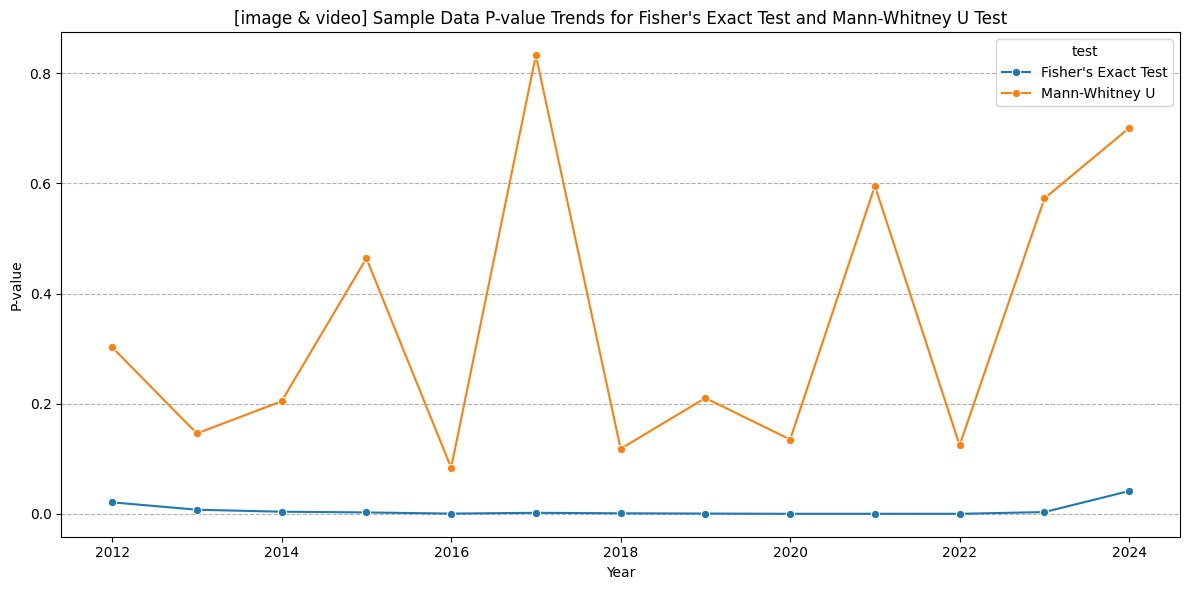

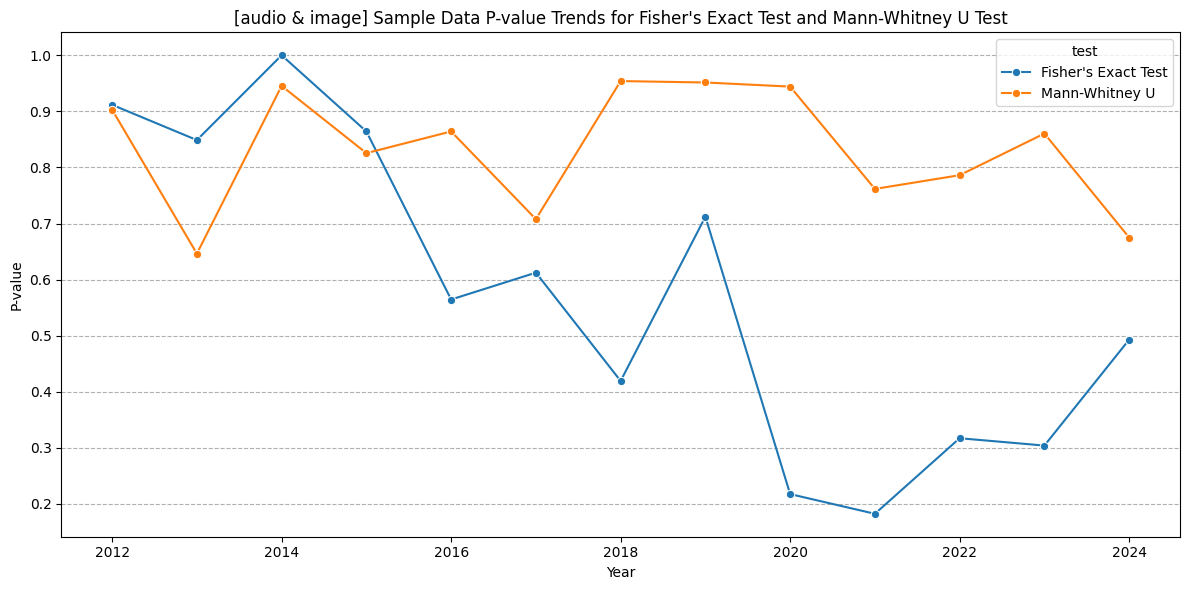

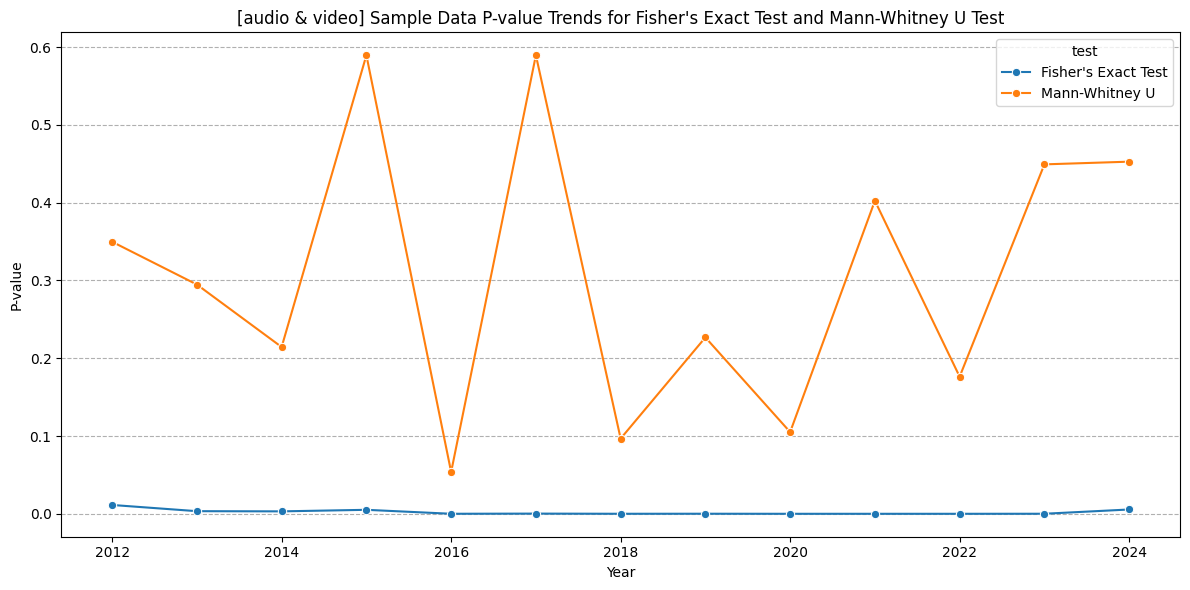

In [110]:
feature = "degree_centrality"
result_df = two_test(G, feature=feature)
result_df.to_csv(os.path.join(OUTPUT_DIR, f"sample_data_Fisher_MW_{feature}.csv"))

plot_p_value("image", "video", result_df, ann="Sample")
plot_p_value("audio", "image", result_df, ann="Sample")
plot_p_value("audio", "video", result_df, ann="Sample")

#### Betweenness Centrality

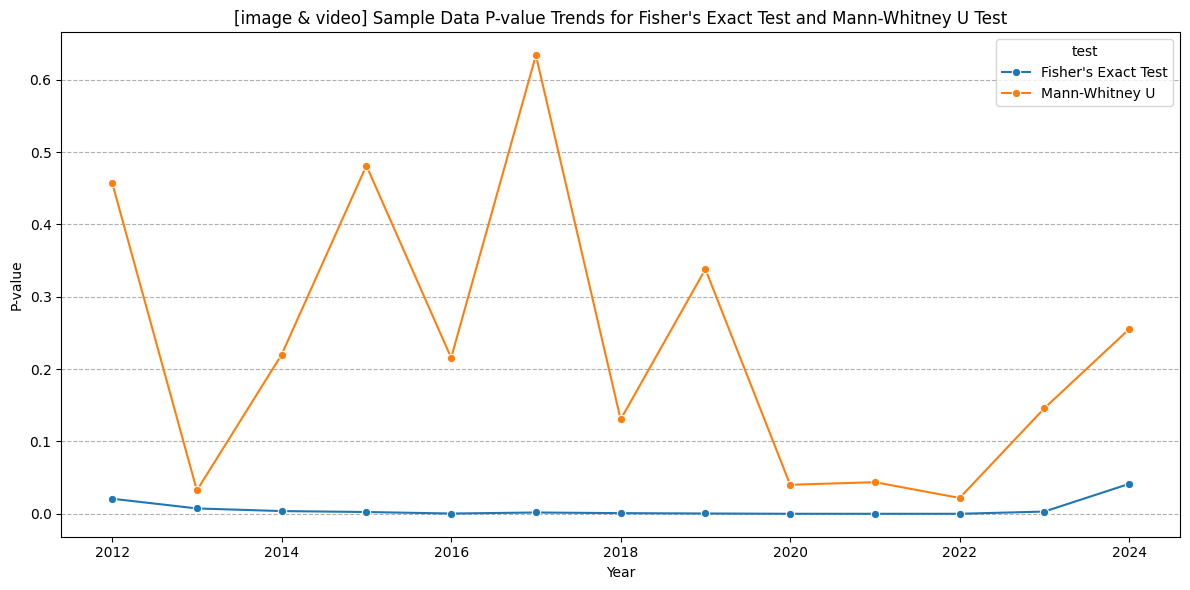

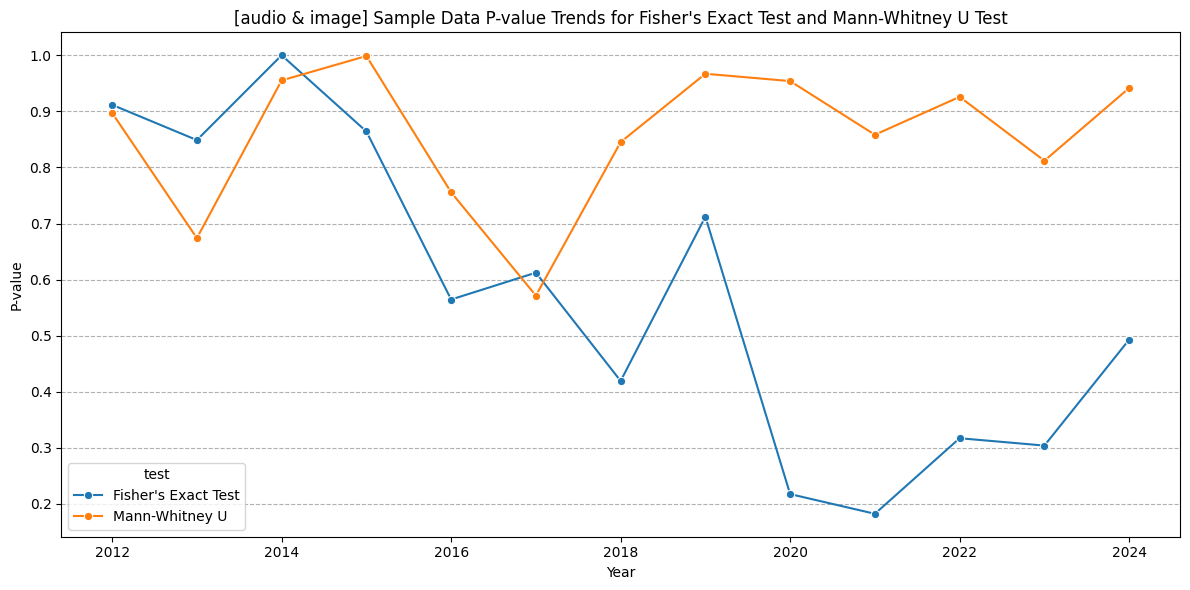

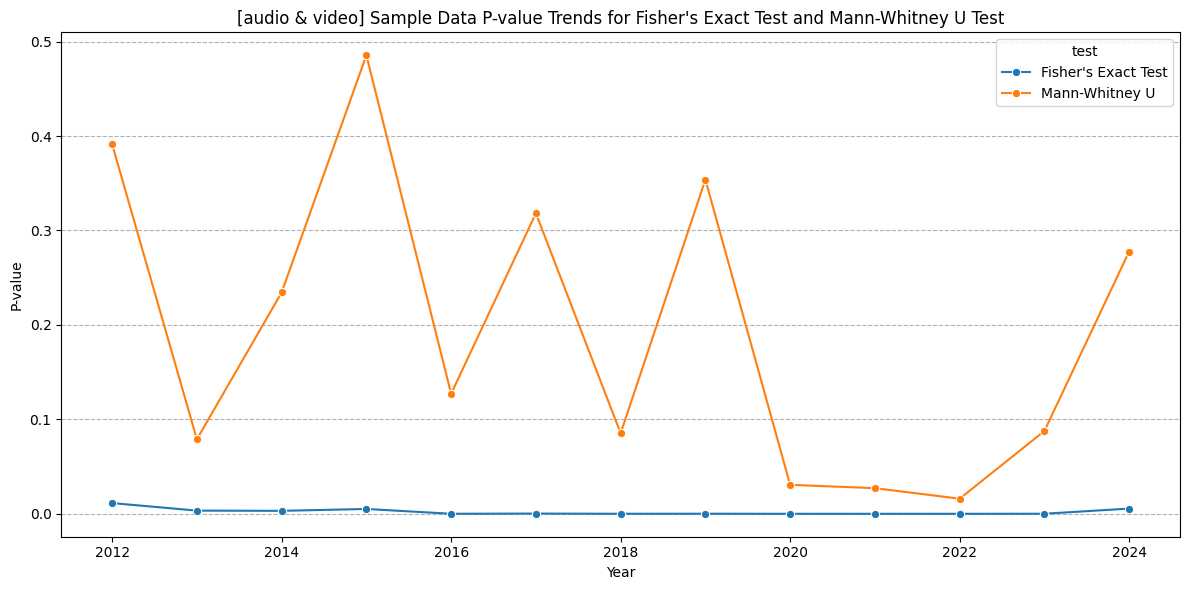

In [112]:
feature = "betweenness_centrality"
result_df = two_test(G, feature=feature)
result_df.to_csv(os.path.join(OUTPUT_DIR, f"sample_data_Fisher_MW_{feature}.csv"))

plot_p_value("image", "video", result_df, ann="Sample")
plot_p_value("audio", "image", result_df, ann="Sample")
plot_p_value("audio", "video", result_df, ann="Sample")

#### Closeness Centrality

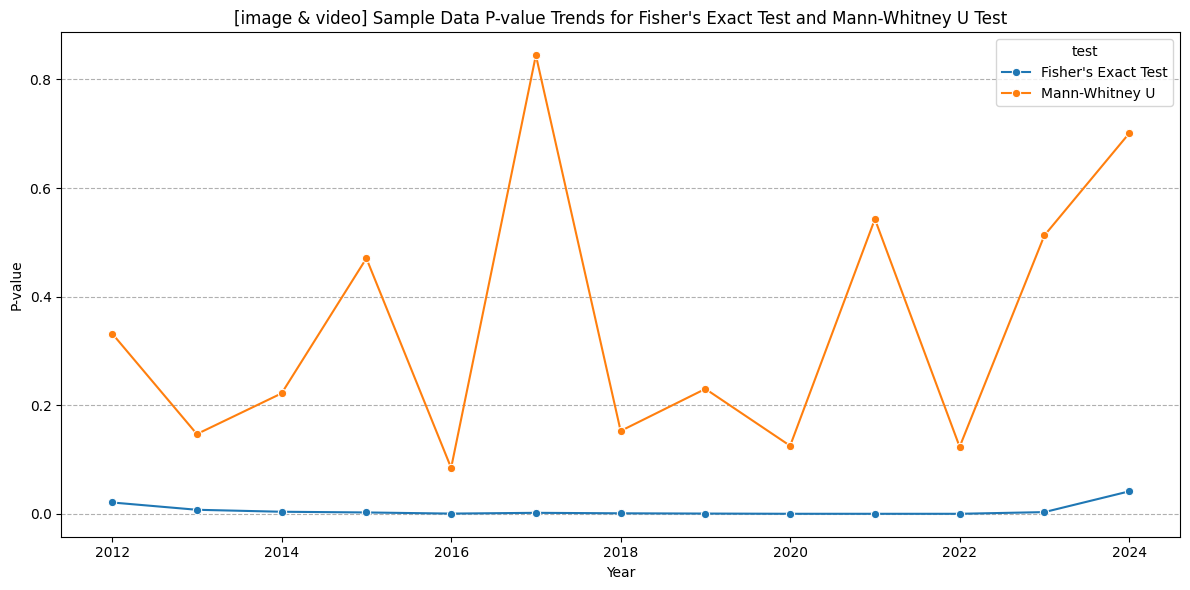

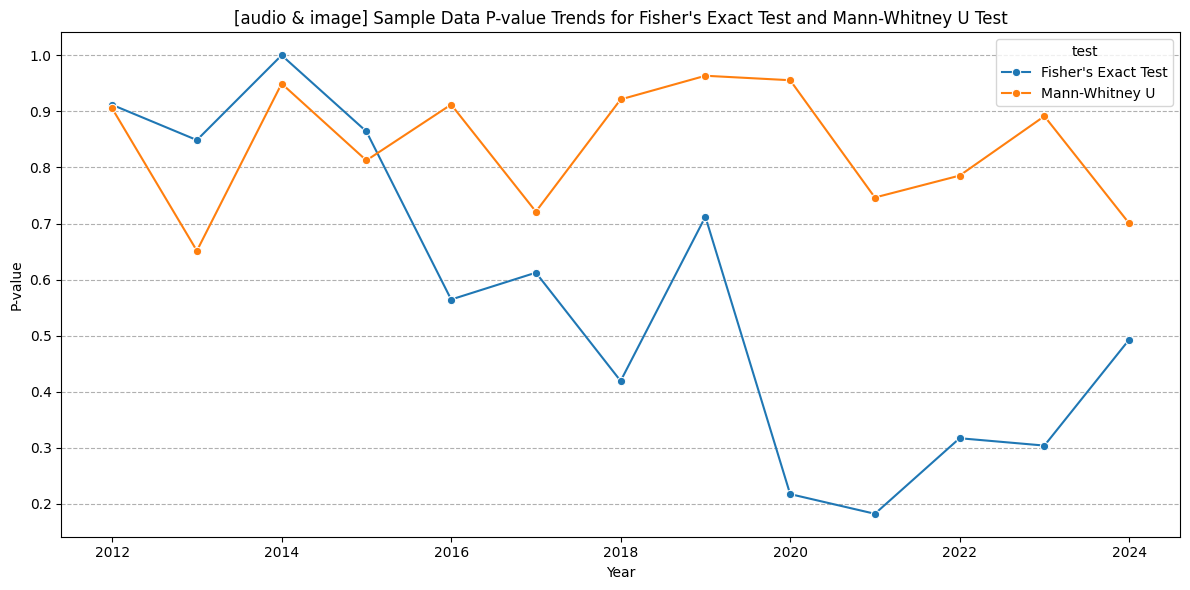

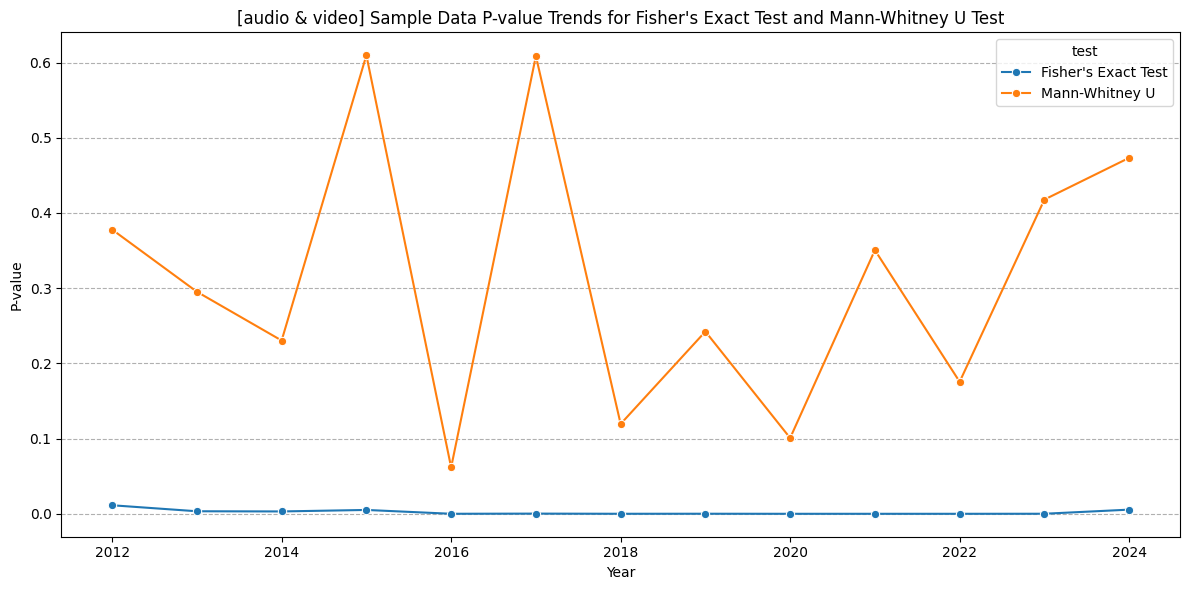

In [114]:
feature = "closeness_centrality"
result_df = two_test(G, feature=feature)
result_df.to_csv(os.path.join(OUTPUT_DIR, f"sample_data_Fisher_MW_{feature}.csv"))

plot_p_value("image", "video", result_df, ann="Sample")
plot_p_value("audio", "image", result_df, ann="Sample")
plot_p_value("audio", "video", result_df, ann="Sample")

#### Eigenvector Centrality

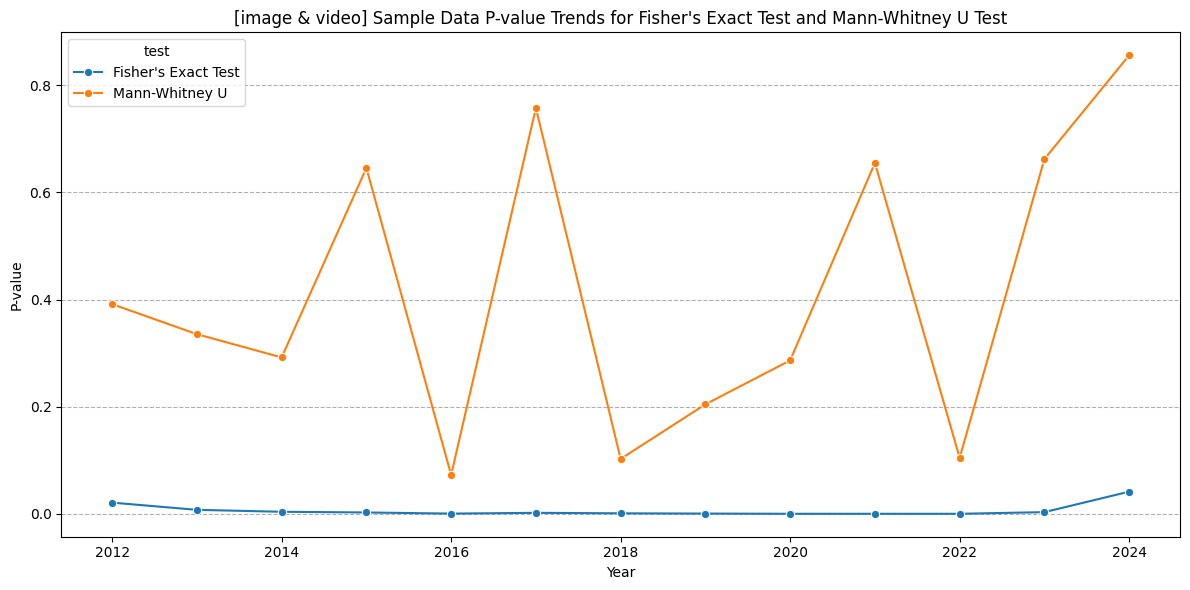

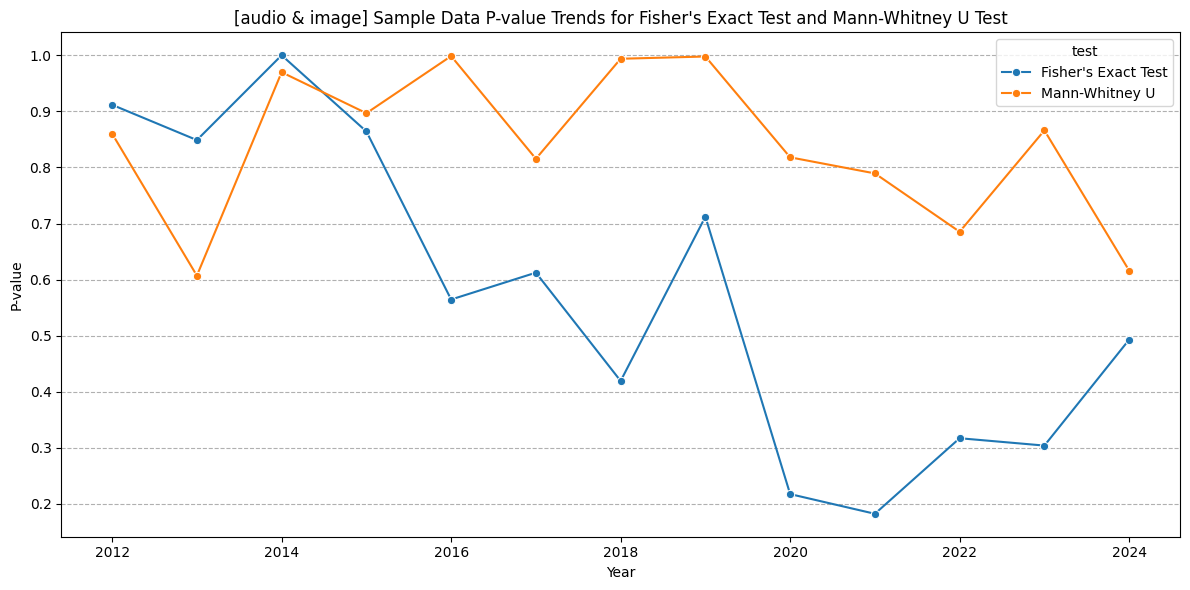

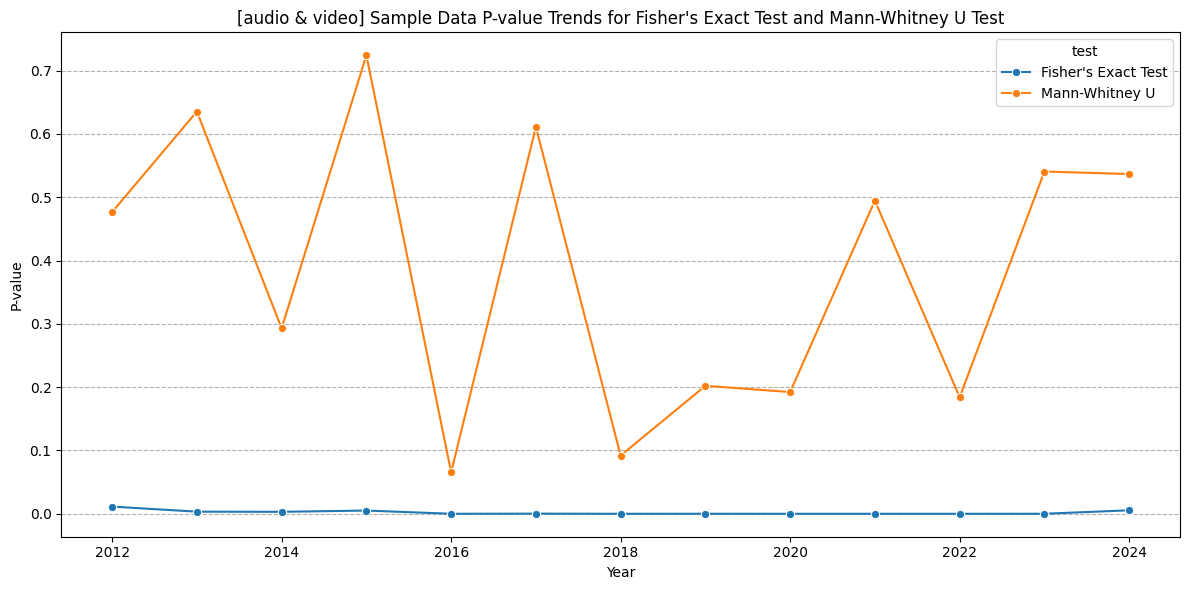

In [113]:
feature = "eigenvector_centrality"
result_df = two_test(G, feature=feature)
result_df.to_csv(os.path.join(OUTPUT_DIR, f"sample_data_Fisher_MW_{feature}.csv"))

plot_p_value("image", "video", result_df, ann="Sample")
plot_p_value("audio", "image", result_df, ann="Sample")
plot_p_value("audio", "video", result_df, ann="Sample")

#### Modularity Communities

In [128]:
# Fisher's Exact Test
for community in set(graph_stat['modularity_communities'].values()):
    community_nodes = [node for node in G.nodes if 'community' in G.nodes[node] and G.nodes[node]['community'] == community]
    
    image_contributions_count = 0
    video_contributions_count = 0
    image_no_contributions_count = 0
    video_no_contributions_count = 0
    
    for node in community_nodes:
        image_contributions = sum(1 for count, date in G.nodes[node]['image_contributions'] if start_date <= datetime.strptime(date, "%Y-%m-%d") <= end_date)
        video_contributions = sum(1 for count, date in G.nodes[node]['video_contributions'] if start_date <= datetime.strptime(date, "%Y-%m-%d") <= end_date)
        
        if image_contributions > 0:
            image_contributions_count += 1
        else:
            image_no_contributions_count += 1
        
        if video_contributions > 0:
            video_contributions_count += 1
        else:
            video_no_contributions_count += 1
    
    # input data
    contingency_table = [[image_contributions_count, image_no_contributions_count], [video_contributions_count, video_no_contributions_count]]
    oddsratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
    
    print(f"{p_value < 0.05} 社区 {community} 的 Fisher's Exact Test 统计量: {oddsratio}, p值: {p_value}")
        
    # Mann-Whitney U
    stat, mw_p_value = mannwhitneyu(audio_centralities, image_centralities)
    
    print(f"{mw_p_value < 0.05} 社区 {community} 的 Mann-Whitney U 统计量: {stat}, p值: {mw_p_value}")


False 社区 0 的 Fisher's Exact Test 统计量: 1.0, p值: 1.0
False 社区 0 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 1 的 Fisher's Exact Test 统计量: 1.3559322033898304, p值: 0.3776018555216324
False 社区 1 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 2 的 Fisher's Exact Test 统计量: 1.3971248876909255, p值: 0.11327044794047515
False 社区 2 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 3 的 Fisher's Exact Test 统计量: 0.9108875314408911, p值: 0.7460015433926678
False 社区 3 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 4 的 Fisher's Exact Test 统计量: 1.4825174825174825, p值: 0.09677120539066918
False 社区 4 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 5 的 Fisher's Exact Test 统计量: 1.2245322245322245, p值: 0.5698923690859214
False 社区 5 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388


### Full Data

In [116]:
num_sample_item = None
if num_sample_item is None:
    graph_stat_path = os.path.join(OUTPUT_DIR, f"graph_stat.pkl")
else:
    graph_stat_path = os.path.join(OUTPUT_DIR, f"graph_stat_{num_sample_item}.pkl")
with open(graph_stat_path, "rb") as f:
    graph_stat = pickle.load(f)

# 创建图
G = nx.Graph()

# 添加节点
for node in tqdm(graph_stat['degree_centrality'].keys()):
    edit_history = editor_data[node]
    image_count = edit_history[edit_history.image_item == True].groupby(by="timestamp").count()
    video_count = edit_history[edit_history.video_item == True].groupby(by="timestamp").count()
    audio_count = edit_history[edit_history.audio_item == True].groupby(by="timestamp").count()
    G.add_node(node, 
               degree_centrality=graph_stat['degree_centrality'][node],
               betweenness_centrality=graph_stat['betweenness_centrality'][node],
               closeness_centrality=graph_stat['closeness_centrality'][node],
               eigenvector_centrality=graph_stat['eigenvector_centrality'][node],
               community=graph_stat['modularity_communities'][node],
               edited_image=edit_history.image_item.max() == 1,  # 编辑过图片
               edited_video=edit_history.audio_item.max() == 1,  # 编辑过视频
               edited_audio=edit_history.video_item.max() == 1,  # 编辑过音频
               image_contributions=[(c, d) for d, c in zip(image_count.index, image_count.editor.values)],
               video_contributions=[(c, d) for d, c in zip(video_count.index, video_count.editor.values)],
               audio_contributions=[(c, d) for d, c in zip(audio_count.index, audio_count.editor.values)],
              )
    
full_edit_records = pd.read_csv(os.path.join(DATA_DIR, "multi-media_editors", "2type_editors_full.csv"), index_col="Unnamed: 0")
    
# 添加边
for item_id, grp in tqdm(full_edit_records.groupby(by="item")):
    editors_of_item = np.unique(grp.editor.values)
    for i, editor in enumerate(editors_of_item):
        for coeditor in editors_of_item[i + 1:]:  
            G.add_edge(editor, coeditor)

100%|██████████| 828/828 [00:05<00:00, 163.24it/s]


#### Degree Centrality

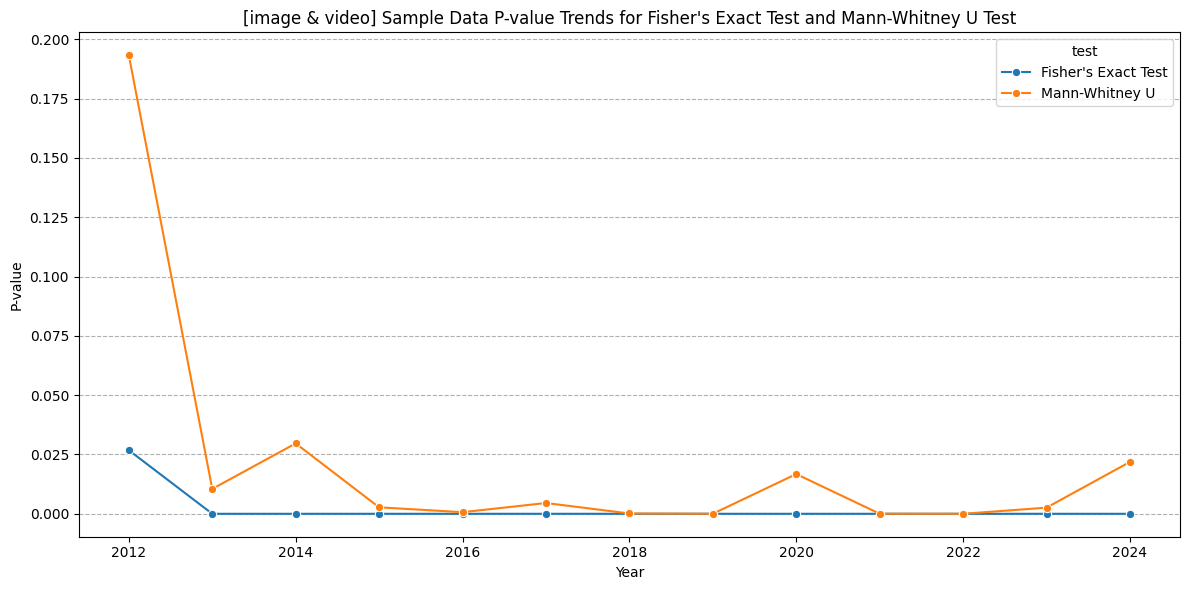

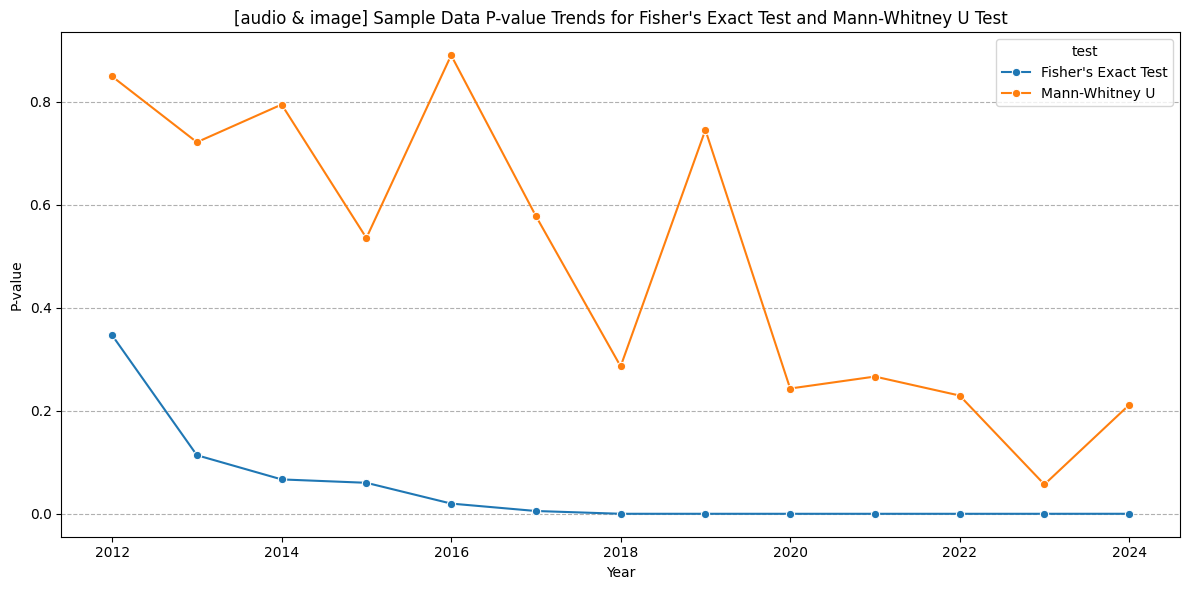

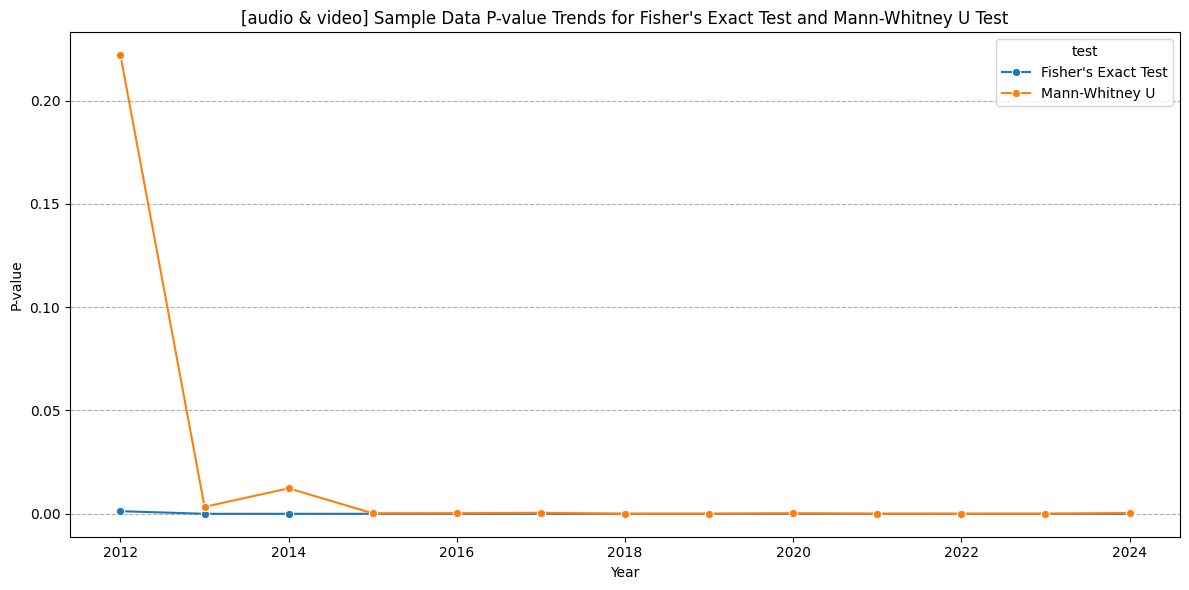

In [117]:
feature = "degree_centrality"
result_df = two_test(G, feature=feature)
result_df.to_csv(os.path.join(OUTPUT_DIR, f"full_data_Fisher_MW_{feature}.csv"))

plot_p_value("image", "video", result_df, ann="Sample")
plot_p_value("audio", "image", result_df, ann="Sample")
plot_p_value("audio", "video", result_df, ann="Sample")

#### Betweenness Centrality

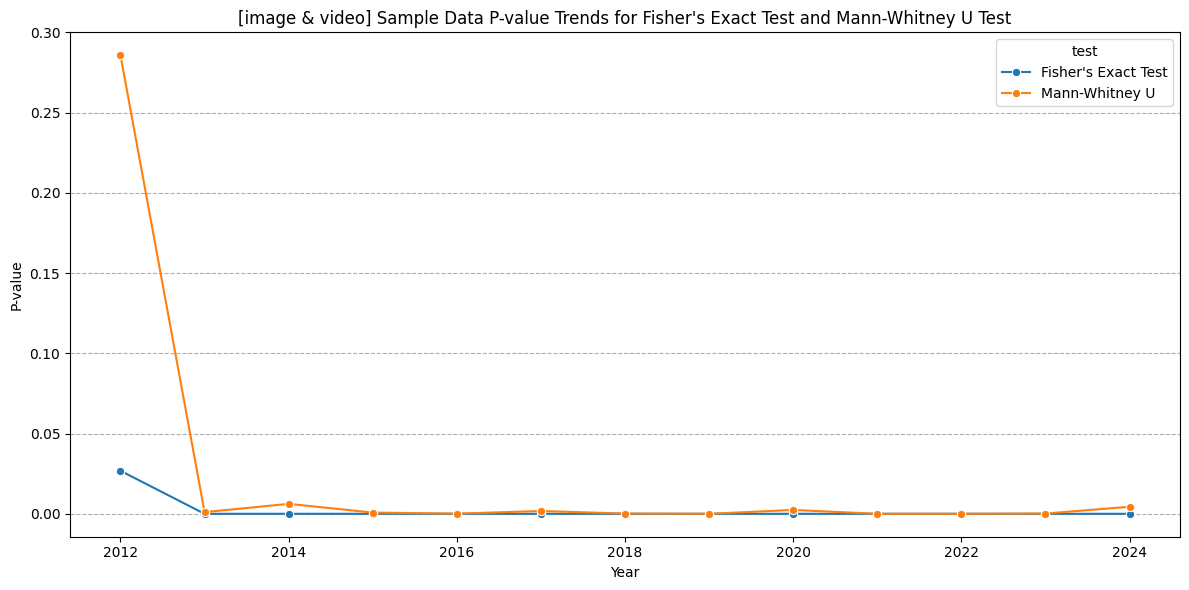

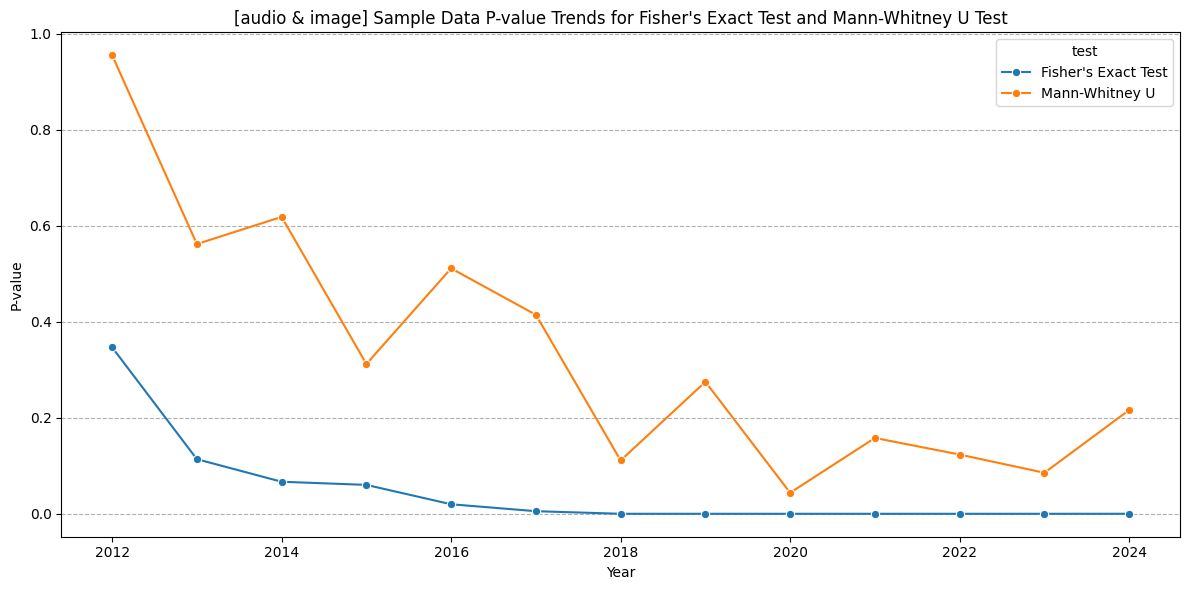

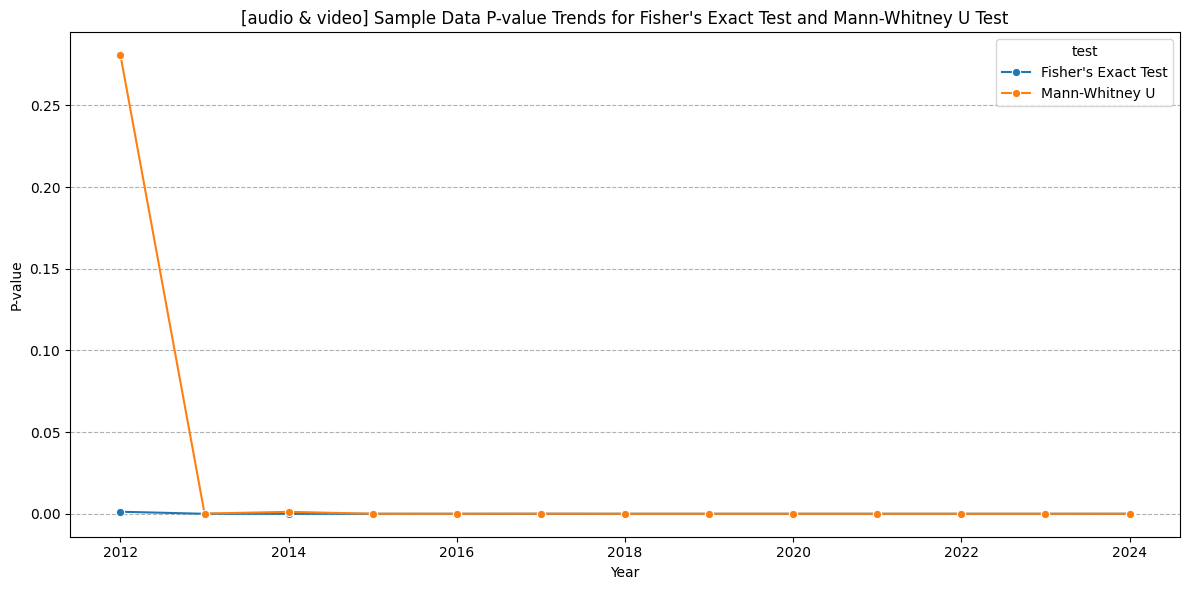

In [118]:
feature = "betweenness_centrality"
result_df = two_test(G, feature=feature)
result_df.to_csv(os.path.join(OUTPUT_DIR, f"full_data_Fisher_MW_{feature}.csv"))

plot_p_value("image", "video", result_df, ann="Sample")
plot_p_value("audio", "image", result_df, ann="Sample")
plot_p_value("audio", "video", result_df, ann="Sample")

#### Closeness Centrality

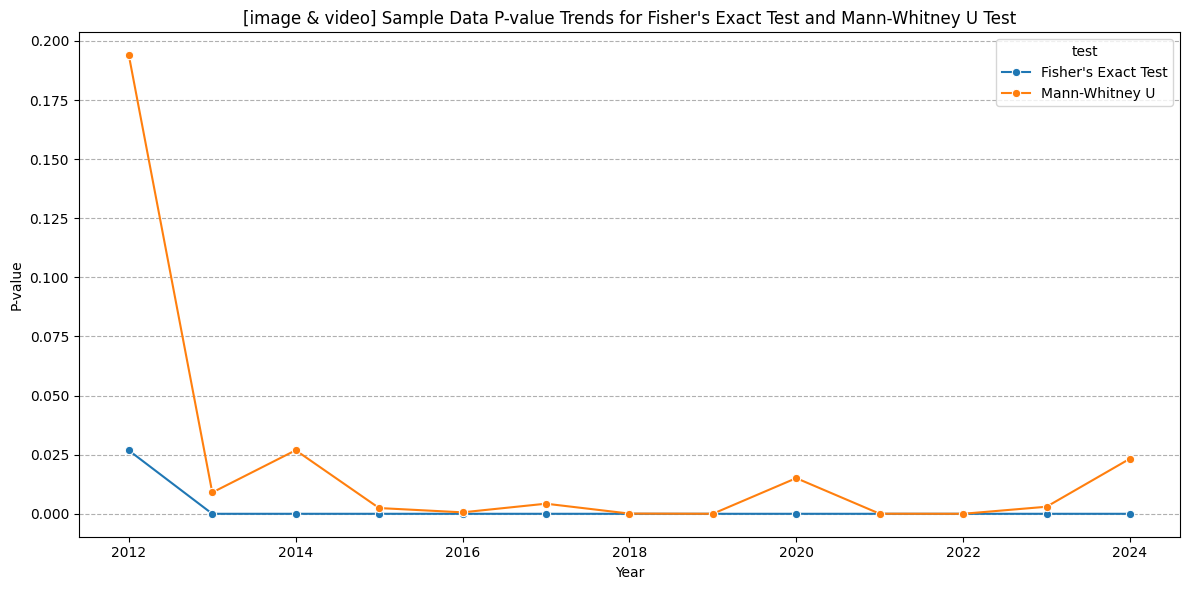

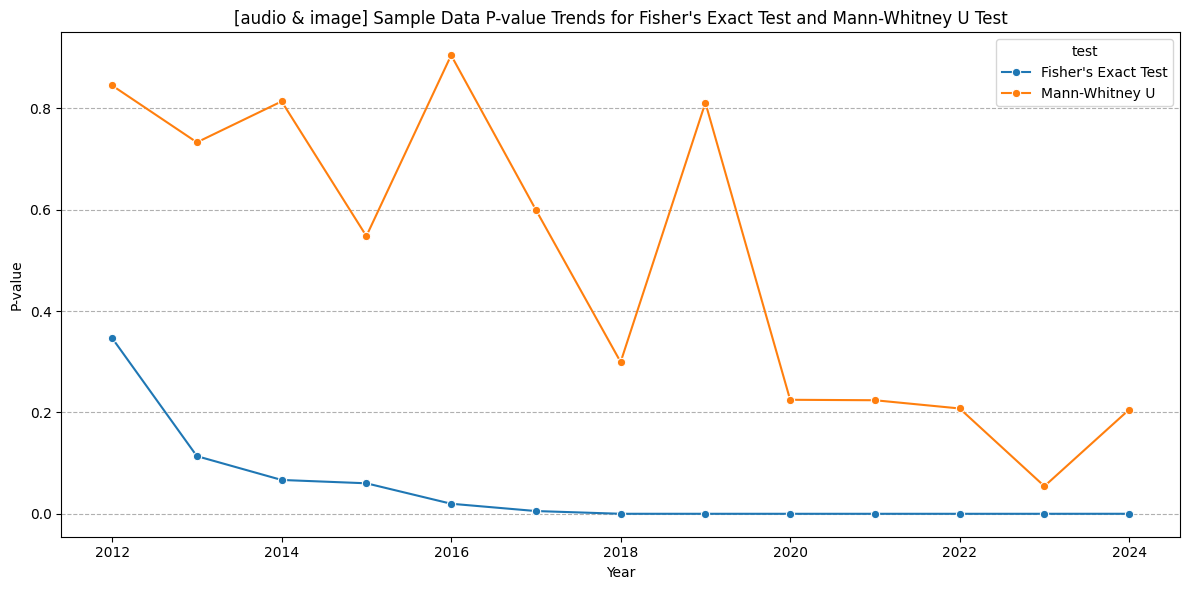

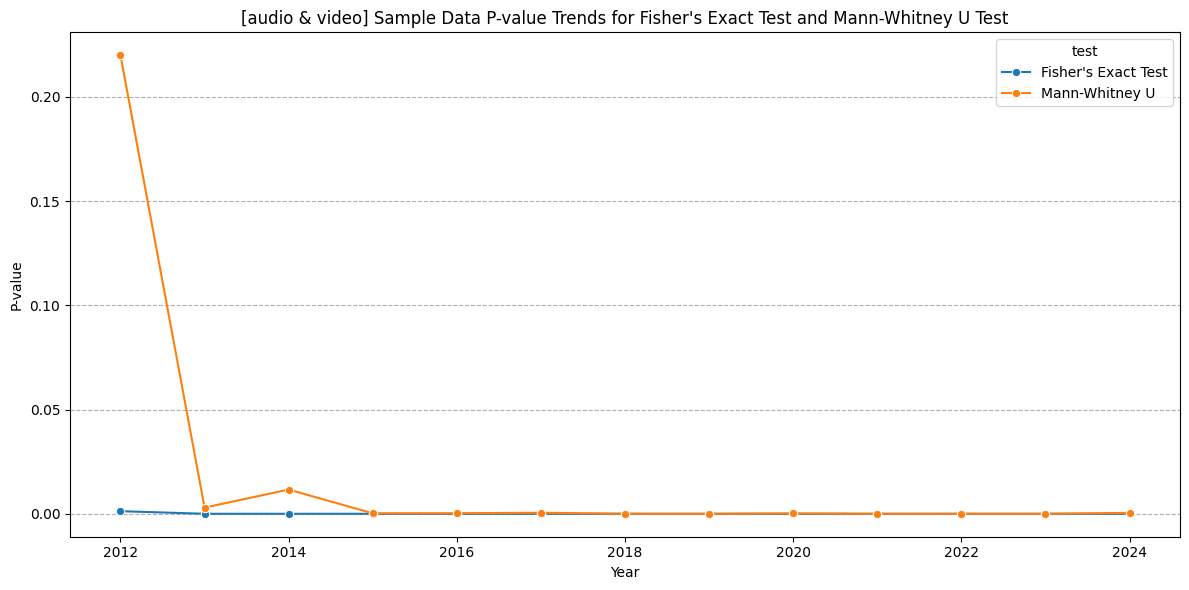

In [119]:
feature = "closeness_centrality"
result_df = two_test(G, feature=feature)
result_df.to_csv(os.path.join(OUTPUT_DIR, f"full_data_Fisher_MW_{feature}.csv"))

plot_p_value("image", "video", result_df, ann="Sample")
plot_p_value("audio", "image", result_df, ann="Sample")
plot_p_value("audio", "video", result_df, ann="Sample")

#### Eigenvector Centrality

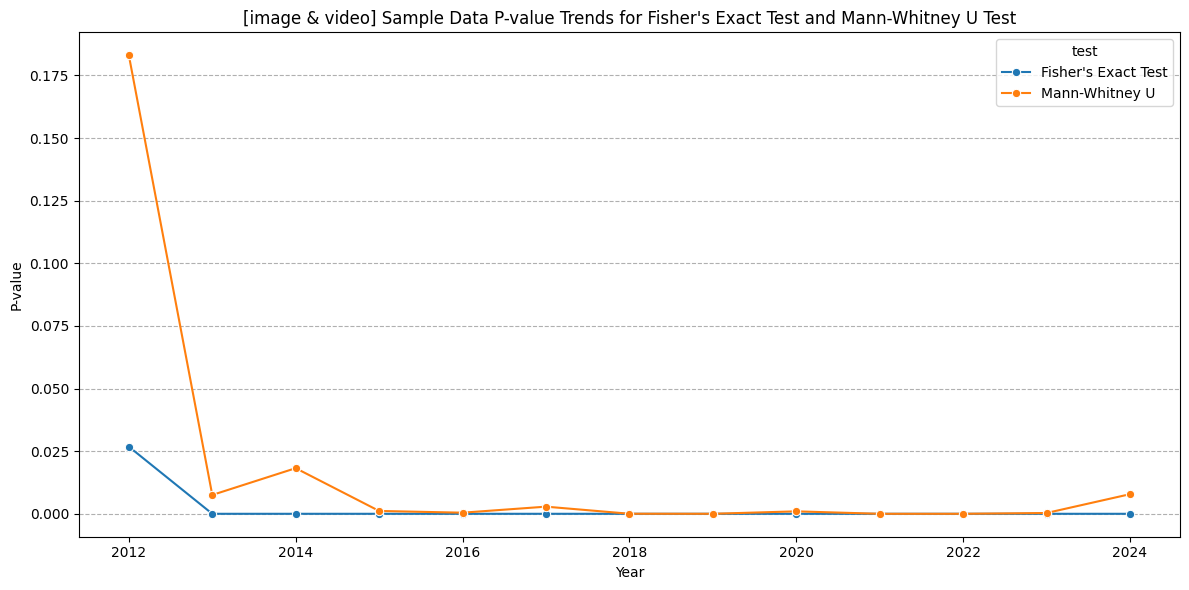

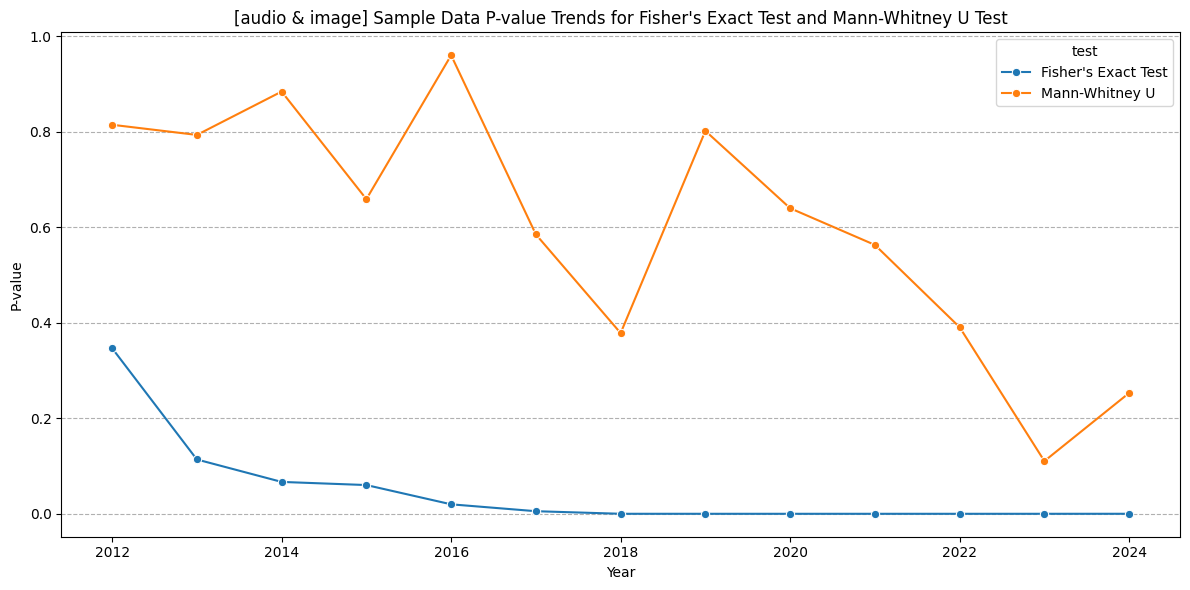

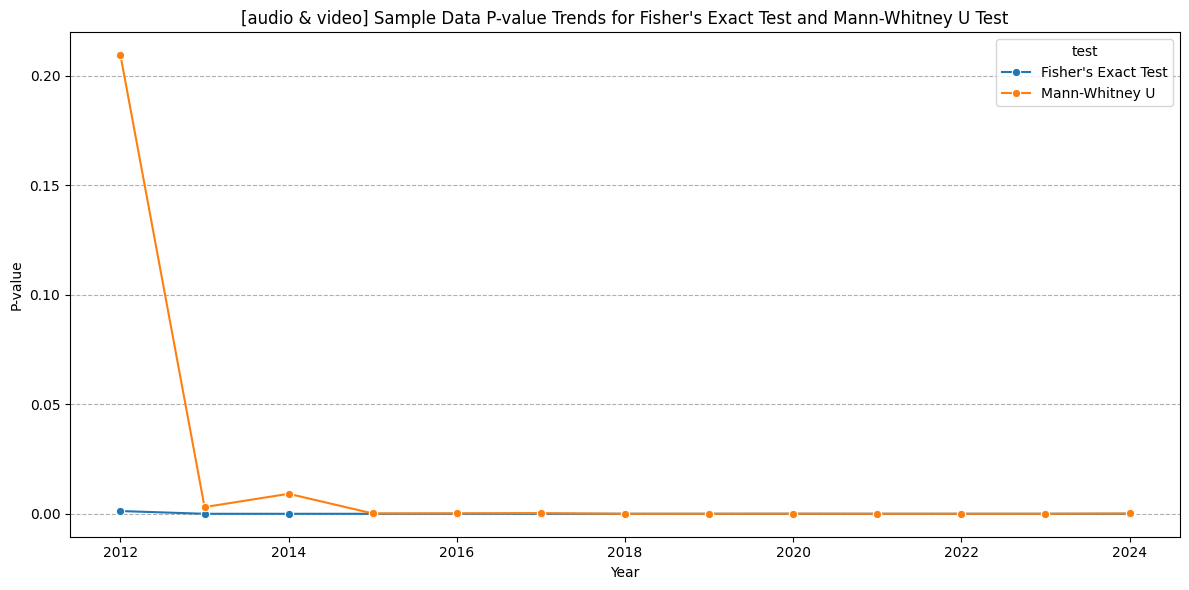

In [120]:
feature = "eigenvector_centrality"
result_df = two_test(G, feature=feature)
result_df.to_csv(os.path.join(OUTPUT_DIR, f"full_data_Fisher_MW_{feature}.csv"))

plot_p_value("image", "video", result_df, ann="Sample")
plot_p_value("audio", "image", result_df, ann="Sample")
plot_p_value("audio", "video", result_df, ann="Sample")

#### Modularity Communities

In [124]:
# Fisher's Exact Test
for community in set(graph_stat['modularity_communities'].values()):
    community_nodes = [node for node in G.nodes if 'community' in G.nodes[node] and G.nodes[node]['community'] == community]
    
    image_contributions_count = 0
    video_contributions_count = 0
    image_no_contributions_count = 0
    video_no_contributions_count = 0
    
    for node in community_nodes:
        image_contributions = sum(1 for count, date in G.nodes[node]['image_contributions'] if start_date <= datetime.strptime(date, "%Y-%m-%d") <= end_date)
        video_contributions = sum(1 for count, date in G.nodes[node]['video_contributions'] if start_date <= datetime.strptime(date, "%Y-%m-%d") <= end_date)
        
        if image_contributions > 0:
            image_contributions_count += 1
        else:
            image_no_contributions_count += 1
        
        if video_contributions > 0:
            video_contributions_count += 1
        else:
            video_no_contributions_count += 1
    
    # input data
    contingency_table = [[image_contributions_count, image_no_contributions_count], [video_contributions_count, video_no_contributions_count]]
    oddsratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
    
    print(f"{p_value < 0.05} 社区 {community} 的 Fisher's Exact Test 统计量: {oddsratio}, p值: {p_value}")
        
    # Mann-Whitney U
    stat, mw_p_value = mannwhitneyu(audio_centralities, image_centralities)
    
    print(f"{mw_p_value < 0.05} 社区 {community} 的 Mann-Whitney U 统计量: {stat}, p值: {mw_p_value}")

True 社区 0 的 Fisher's Exact Test 统计量: 1.7224740932642486, p值: 0.0007811179459192456
False 社区 0 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 1 的 Fisher's Exact Test 统计量: 0.900051652892562, p值: 0.3167789512058675
False 社区 1 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
True 社区 2 的 Fisher's Exact Test 统计量: 2.132936507936508, p值: 1.1062791069653316e-06
False 社区 2 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
True 社区 3 的 Fisher's Exact Test 统计量: 4.545454545454546, p值: 0.026913893997221536
False 社区 3 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 4 的 Fisher's Exact Test 统计量: 1.909334225493476, p值: 0.07403466650071792
False 社区 4 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 5 的 Fisher's Exact Test 统计量: 1.0, p值: 1.0
False 社区 5 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
False 社区 6 的 Fisher's Exact Test 统计量: 1.2738095238095237, p值: 0.8068338873395103
False 社区 6 的 Mann-Whitney U 统计量: 35265.0, p值: 0.6750477919017388
True 